In [25]:
import abc
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import f1_score, accuracy_score
import tensorflow.keras.datasets.reuters as reuters
import tensorflow.keras.activations
import matplotlib.pyplot as plt
tf.random.set_seed(1234)

# Dane

In [46]:
dict_size = 20
(x_train, y_train), (x_test, y_test) = reuters.load_data(test_split=0.3,num_words=dict_size)
unique, frequency = np.unique(y_train,  
                              return_counts = True) 
x_train.shape

(7859,)

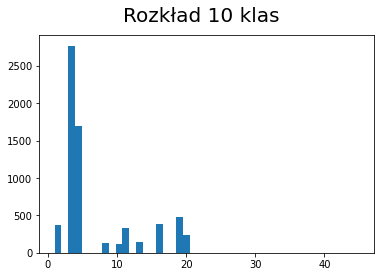

In [27]:
classes = pd.DataFrame({'classes' : unique, 'frequency' : frequency}).nlargest(10,'frequency')
fig = plt.figure()
fig.suptitle('Rozkład 10 klas', fontsize=20)
plt.hist(x=classes.classes,weights=classes.frequency,bins=45,range=(1,45))
plt.show()

In [28]:
train_set = pd.DataFrame({'x':x_train,'y':y_train})
test_set = pd.DataFrame({'x':x_test,'y':y_test})
train_set

,x,y
0,"[1, 2, 2, 8, 2, 10, 2, 5, 2, 2, 2, 5, 2, 2, 16...",3
1,"[1, 2, 2, 2, 2, 2, 2, 2, 9, 2, 2, 2, 2, 5, 2, ...",4
2,"[1, 2, 12, 2, 15, 14, 2, 2, 2, 2, 2, 2, 15, 14...",3
3,"[1, 4, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",4
4,"[1, 2, 2, 8, 2, 2, 2, 2, 10, 2, 2, 2, 9, 2, 2,...",4
...,...,...
7854,"[1, 2, 2, 2, 2, 2, 2, 10, 2, 5, 2, 2, 9, 2, 2,...",3
7855,"[1, 2, 2, 2, 2, 2, 8, 16, 2, 2, 2, 2, 2, 6, 2,...",4
7856,"[1, 2, 2, 2, 8, 16, 2, 10, 2, 5, 2, 6, 2, 2, 2...",4
7857,"[1, 2, 2, 9, 2, 2, 8, 16, 2, 2, 2, 2, 2, 2, 9,...",16


In [29]:
train_set.y.isin(classes['classes'])

0       True
1       True
2       True
3       True
4       True
        ... 
7854    True
7855    True
7856    True
7857    True
7858    True
Name: y, Length: 7859, dtype: bool

In [30]:
filtered_train_set = train_set[train_set.y.isin(classes['classes'])]
filtered_train_set['y']=filtered_train_set['y'].astype('category').cat.codes
filtered_test_set  = test_set[test_set.y.isin(classes['classes'])]
filtered_test_set['y']=filtered_test_set['y'].astype('category').cat.codes

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [31]:
def plot_hist(dataset,title):
    fig = plt.figure()
    fig.suptitle('Rozkład klas ' + title, fontsize=20)
    plt.hist(x=dataset.y)
    plt.show()

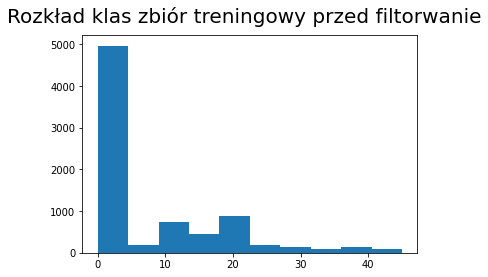

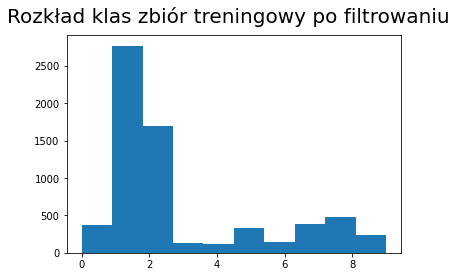

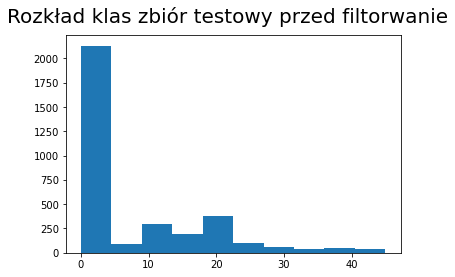

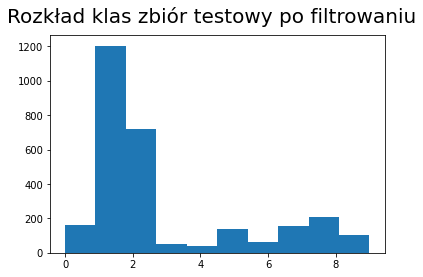

In [32]:
plot_hist(train_set,"zbiór treningowy przed filtorwanie")
plot_hist(filtered_train_set,"zbiór treningowy po filtrowaniu")
plot_hist(test_set,"zbiór testowy przed filtorwanie")
plot_hist(filtered_test_set,"zbiór testowy po filtrowaniu")


# Model rekurecyjny

In [9]:
class AbstractLayer(tf.keras.layers.Layer):
    """Abstract Layer."""
    
    def __init__(self):
        """Inits the class."""
        super(AbstractLayer, self).__init__()
    
    @abc.abstractmethod
    def call(self, inputs):
        """Makes forward pass of the layer."""
        pass
    
class Custom_Embedding_layer(AbstractLayer):
    
    def __init__(self,embedding_size,Dim):
        """Inits the class."""
        super(Custom_Embedding_layer, self).__init__()
        self.embedding_table = self.add_weight(shape=(Dim,embedding_size),
                                      initializer=tf.random_normal_initializer,
                                      trainable=True)
        
    def call(self, inputs):
        """Makes forward pass of the layer."""
        #inputs should be after padding
        word_embeddings = tf.nn.embedding_lookup(self.embedding_table,inputs)
        return word_embeddings
    
class Custom_RNN(AbstractLayer):
    
    def __init__(self, hidden_state_size, output_size,): 
        super(Custom_RNN, self).__init__()
        self.tahn = tensorflow.keras.activations.tanh
        self.softmax = tensorflow.keras.activations.softmax
        self.output_size = output_size
        self.hidden_state_size = hidden_state_size
        
    def build(self, input_shape):
        self.Whx = self.add_weight(shape=(self.hidden_state_size,input_shape[-1]),
                                      initializer=tf.random_uniform_initializer,
                                      trainable=True)
        
        self.Whh = self.add_weight(shape=(self.hidden_state_size, self.hidden_state_size),
                                      initializer=tf.random_uniform_initializer,
                                      trainable=True)
        
        self.Why = self.add_weight(shape=(self.output_size,self.hidden_state_size),
                                      initializer=tf.random_uniform_initializer,
                                      trainable=True)
        
        self.bh = self.add_weight(shape=(self.hidden_state_size,1),initializer=tf.random_uniform_initializer,trainable=True)
        self.by = self.add_weight(shape=(self.output_size,1),initializer=tf.random_uniform_initializer,trainable=True)
           
        
    def step_function(self,inputs,state):
        
        inputs=tf.reshape(inputs,shape=(-1,inputs.shape[1],1))
        state=tf.reshape(state,shape=(-1,self.hidden_state_size,1))
        # h(t) = tahn (Whx*x(t) + Whh*h(t-1)+bh)
        h = self.tahn(tf.matmul(self.Whx,inputs) + tf.matmul(self.Whh,state) + self.bh)
        #print('h',h.shape,self.by.shape)
        sum = tf.matmul(self.Why,h) + self.by
        # y(t) = softmax (Wyh * h(t)  +by)
        output = self.softmax(sum,axis=0)
        return output, h
    
    
    def call(self, inputs):
        """Makes forward pass of the layer."""
        initial_states = tf.zeros(shape=[inputs.shape[0],self.hidden_state_size,1])
      #  print(inputs.shape)
        last, outputs, states = tf.keras.backend.rnn(self.step_function, inputs, [initial_states])
        #print(last)
        last = tf.reshape(last,(-1,self.output_size))
        #print('after',last)
        return last
     

In [10]:
class Custom_LSTM(AbstractLayer):
    
    def __init__(self, hidden_state_size, output_size,): 
        super(Custom_LSTM, self).__init__()
        self.tahn = tensorflow.keras.activations.tanh
        self.softmax = tensorflow.keras.activations.softmax
        self.sigmoid = tensorflow.keras.activations.sigmoid
        
        self.output_size = output_size
        self.hidden_state_size = hidden_state_size
        
        self.point_wise_multi = tf.math.multiply
        self.point_wise_add = tf.math.add
        
    def build(self, input_shape):
        self.concat_size = self.hidden_state_size+input_shape[2]
        i = input_shape[-1]
        self.Whf = self.add_weight(shape=(self.hidden_state_size,self.hidden_state_size),
                                      initializer=tf.random_uniform_initializer,
                                      trainable=True)
        self.Whu = self.add_weight(shape=(self.hidden_state_size,self.hidden_state_size),
                                      initializer=tf.random_uniform_initializer,
                                      trainable=True)
        self.Whc = self.add_weight(shape=(self.hidden_state_size,self.hidden_state_size),
                                      initializer=tf.random_uniform_initializer,
                                      trainable=True)
        self.Who = self.add_weight(shape=(self.hidden_state_size,self.hidden_state_size),
                                      initializer=tf.random_uniform_initializer,
                                      trainable=True)
        
        self.Wfx = self.add_weight(shape=(self.hidden_state_size,input_shape[-1]),
                                      initializer=tf.random_uniform_initializer,
                                      trainable=True)
        self.Wxu = self.add_weight(shape=(self.hidden_state_size,input_shape[-1]),
                                      initializer=tf.random_uniform_initializer,
                                      trainable=True)
        self.Wxc = self.add_weight(shape=(self.hidden_state_size,input_shape[-1]),
                                      initializer=tf.random_uniform_initializer,
                                      trainable=True)
        self.Wxo = self.add_weight(shape=(self.hidden_state_size,input_shape[-1]),
                                      initializer=tf.random_uniform_initializer,
                                      trainable=True)
        
        self.bf = self.add_weight(shape=(self.hidden_state_size,1),initializer=tf.random_uniform_initializer,trainable=True)
        self.bi = self.add_weight(shape=(self.hidden_state_size,1),initializer=tf.random_uniform_initializer,trainable=True)
        self.bc = self.add_weight(shape=(self.hidden_state_size,1),initializer=tf.random_uniform_initializer,trainable=True)
        self.bo = self.add_weight(shape=(self.hidden_state_size,1),initializer=tf.random_uniform_initializer,trainable=True)
    
        self.Why = self.add_weight(shape=(self.output_size,self.hidden_state_size),
                                      initializer=tf.random_uniform_initializer,
                                      trainable=True)
        self.by = self.add_weight(shape=(self.output_size,1),initializer=tf.random_uniform_initializer,trainable=True)
        pass
           
        
    def step_function(self,inputs,state):
        inputs=tf.reshape(inputs,shape=(-1,inputs.shape[1],1))
        H_state=tf.reshape(state[0],shape=(-1,self.hidden_state_size,1))
        C_state=tf.reshape(state[1],shape=(-1,self.hidden_state_size,1))

        matmul1 = tf.matmul(self.Whf,H_state)
        matmul2 = tf.matmul(self.Wfx,inputs)
        ft=self.sigmoid(tf.matmul(self.Whf,H_state)+tf.matmul(self.Wfx,inputs)+self.bf)
        ut=self.sigmoid(tf.matmul(self.Whu,H_state)+tf.matmul(self.Wxu,inputs)+self.bi)
        cti=self.tahn(tf.matmul(self.Whc,H_state)+tf.matmul(self.Wxc,inputs)+self.bc)
        
        ct=self.point_wise_multi(cti,ut)+self.point_wise_multi(C_state,ft)
        
        ot = self.sigmoid(tf.matmul(self.Who,H_state)+tf.matmul(self.Wxo,inputs)+self.bo)
        new_H_state=self.point_wise_multi(ot,self.tahn(ct))
        new_C_state=ct
        
        output =tf.matmul(self.Why,new_H_state)+self.by
        output = self.softmax(output,axis=1)
        
        
        new_states = [new_H_state,new_C_state]
        return output, new_states
   
    
    
    def call(self, inputs):
        """Makes forward pass of the layer."""
        initial_state_h = tf.zeros(shape=[inputs.shape[0],self.hidden_state_size,1])
        initial_state_c = tf.zeros(shape=[inputs.shape[0],self.hidden_state_size,1])
        initial_states = [initial_state_h,initial_state_c]
        last, outputs, states = tf.keras.backend.rnn(self.step_function, inputs, initial_states)
        #print(last)
        last = tf.reshape(last,(-1,self.output_size))
        #print('after',last)
        return last

In [11]:
class AbstractModel(tf.keras.Model):
    """Abstract model."""

    def __init__(self):
        """Inits the class."""
        super(AbstractModel, self).__init__()

    @abc.abstractmethod
    def call(self, inputs, training=False):
        """Makes forward pass of the network."""
        pass

    @abc.abstractmethod
    def predict(self, x):
        """Predicts x"""
        pass
    
class Custom_model_RNN(AbstractModel):
    """Abstract model."""

    def __init__(self,embedding_size,embedding_dim,output_size,hidden_state,rnn_type='rnn'):
        """Inits the class."""
        super(AbstractModel, self).__init__()
        self.embedding = Custom_Embedding_layer(embedding_size,embedding_dim)
       # self.embedding = tf.keras.layers.Embedding(embedding_size, embedding_dim)
        if rnn_type is 'rnn':
          self.rnn = Custom_RNN(hidden_state_size=hidden_state,output_size=output_size)
        elif rnn_type is 'lstm':
          self.rnn = Custom_LSTM(hidden_state_size=hidden_state,output_size=output_size)
        self.output_size=output_size
            
    def call(self, inputs, training=False):
        """Makes forward pass of the network."""
        x=self.embedding(inputs)
        x=self.rnn(x)
        return x

    def predict(self, x):
        """Predicts x"""
        #print("predict")
        pred=self.call(x,trening=False)
        pred = tf.argmax(input=pred,axis=1)
        return pred

In [12]:
def f1(y_true,y_pred):
    #print('true shape: ',y_true.shape)
    #print('predict shape:',y_pred.shape)
    re= tf.argmax(y_pred,axis=1)
    re = tf.reshape(re,[-1,1])
    
    #print(re.shape, y_true.shape)
    F1 = f1_score(y_true=y_true.numpy(),y_pred=re,average="macro")
    #print(F1)
    return F1

# Badania

In [13]:
from google.colab import drive
drive.mount('/content/drive')
log_dir_path = F"/content/drive/"+"My Drive"+"/logs/"

Mounted at /content/drive


In [49]:
maxlen = 60
x_train = filtered_train_set['x']
print(x_train[1],x_train.shape)
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train,maxlen=maxlen)
x_train.shape
print(x_train[1],x_train.shape)
x_train

[1, 2, 2, 2, 2, 2, 2, 2, 9, 2, 2, 2, 2, 5, 2, 2, 2, 2, 2, 2, 2, 7, 2, 2, 2, 2, 2, 2, 2, 2, 8, 7, 10, 2, 16, 2, 2, 2, 2, 5, 4, 2, 2, 2, 2, 2, 7, 2, 2, 2, 2, 2, 2, 2, 17, 12] (6674,)
[ 0  0  0  0  1  2  2  2  2  2  2  2  9  2  2  2  2  5  2  2  2  2  2  2
  2  7  2  2  2  2  2  2  2  2  8  7 10  2 16  2  2  2  2  5  4  2  2  2
  2  2  7  2  2  2  2  2  2  2 17 12] (6674, 60)


array([[15,  2,  2, ..., 15, 17, 12],
       [ 0,  0,  0, ...,  2, 17, 12],
       [ 2,  2,  2, ..., 11, 17, 12],
       ...,
       [ 0,  0,  0, ...,  2, 17, 12],
       [ 2,  6,  4, ...,  2, 17, 12],
       [ 0,  0,  0, ...,  2, 17, 12]], dtype=int32)

In [15]:
model=Custom_model_RNN(embedding_size=128,embedding_dim=dict_size,output_size=10,hidden_state=16,rnn_type='rnn')
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    metrics=[f1],
    run_eagerly=True #for tensor.numpy() in f1 score metric
)

In [16]:
log_dir = log_dir_path+"rnn"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1,)
model.fit(x=x_train,y=filtered_train_set['y'],
          epochs=25, batch_size=200,
          callbacks=[tensorboard_callback])

Epoch 1/25
 1/34 [..............................] - ETA: 0s - loss: 2.3026 - f1: 0.0403WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
34/34 [==============================] - 12s 364ms/step - loss: 2.3023 - f1: 0.0625
Epoch 2/25
34/34 [==============================] - 12s 348ms/step - loss: 2.2798 - f1: 0.0764
Epoch 3/25
34/34 [==============================] - 12s 347ms/step - loss: 2.2046 - f1: 0.0867
Epoch 4/25
34/34 [==============================] - 12s 346ms/step - loss: 2.0148 - f1: 0.0998
Epoch 5/25
34/34 [==============================] - 12s 346ms/step - loss: 1.7839 - f1: 0.0717
Epoch 6/25
34/34 [==============================] - 12s 342ms/step - loss: 1.7433 - f1: 0.0710
Epoch 7/25
34/34 [==============================] - 12s 348ms/step - loss: 1

In [50]:
model=Custom_model_RNN(embedding_size=128,embedding_dim=dict_size,output_size=10,hidden_state=16,rnn_type='lstm')
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    metrics=[f1],
    run_eagerly=True #for tensor.numpy() in f1 score metric
)
log_dir = log_dir_path+"lstm"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1,)
model.fit(x=x_train,y=filtered_train_set['y'],
          epochs=25, batch_size=200,
          callbacks=[tensorboard_callback])

Epoch 1/25
34/34 [==============================] - 31s 907ms/step - loss: 2.2553 - f1: 0.0543
Epoch 2/25
34/34 [==============================] - 30s 883ms/step - loss: 1.8750 - f1: 0.0593
Epoch 3/25
34/34 [==============================] - 29s 865ms/step - loss: 1.7341 - f1: 0.0591
Epoch 4/25
34/34 [==============================] - 30s 884ms/step - loss: 1.7294 - f1: 0.0589
Epoch 5/25
34/34 [==============================] - 29s 853ms/step - loss: 1.7288 - f1: 0.0591
Epoch 6/25
34/34 [==============================] - 29s 854ms/step - loss: 1.7284 - f1: 0.0593
Epoch 7/25
34/34 [==============================] - 29s 853ms/step - loss: 1.7278 - f1: 0.0595
Epoch 8/25
34/34 [==============================] - 29s 853ms/step - loss: 1.7249 - f1: 0.0592
Epoch 9/25
34/34 [==============================] - 29s 858ms/step - loss: 1.7136 - f1: 0.0591
Epoch 10/25
34/34 [==============================] - 29s 858ms/step - loss: 1.6718 - f1: 0.0596
Epoch 11/25
34/34 [==============================

In [21]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(dict_size, 128))
model.add(tf.keras.layers.SimpleRNN(16))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    metrics=[f1],
    run_eagerly=True #for tensor.numpy() in f1 score metric
)

In [22]:
model.fit(x=x_train,y=filtered_train_set['y'],
          epochs=25, batch_size=200
#         callbacks=[tensorboard_callback],
          )

Epoch 1/25
34/34 [==============================] - 4s 105ms/step - loss: 4.2206 - f1: 0.0657
Epoch 2/25
34/34 [==============================] - 3s 102ms/step - loss: 2.6081 - f1: 0.0699
Epoch 3/25
34/34 [==============================] - 3s 102ms/step - loss: 2.4523 - f1: 0.0623
Epoch 4/25
34/34 [==============================] - 3s 102ms/step - loss: 2.4637 - f1: 0.0588
Epoch 5/25
34/34 [==============================] - 3s 102ms/step - loss: 2.4098 - f1: 0.0590
Epoch 6/25
34/34 [==============================] - 3s 102ms/step - loss: 2.4884 - f1: 0.0610
Epoch 7/25
34/34 [==============================] - 4s 103ms/step - loss: 2.4937 - f1: 0.0596
Epoch 8/25
34/34 [==============================] - 3s 102ms/step - loss: 2.4174 - f1: 0.0627
Epoch 9/25
34/34 [==============================] - 3s 101ms/step - loss: 2.4061 - f1: 0.0599
Epoch 10/25
34/34 [==============================] - 4s 103ms/step - loss: 2.3829 - f1: 0.0597
Epoch 11/25
34/34 [==============================] - 3s 103

In [34]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(dict_size, 128))
model.add( tf.keras.layers.LSTM(16))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    metrics=[f1],
    run_eagerly=True #for tensor.numpy() in f1 score metric
)
model.fit(x=x_train,y=filtered_train_set['y'],
          epochs=25, batch_size=200
#         callbacks=[tensorboard_callback],
          )

Epoch 1/25
34/34 [==============================] - 5s 138ms/step - loss: 3.6690 - f1: 0.0589
Epoch 2/25
34/34 [==============================] - 5s 138ms/step - loss: 3.3805 - f1: 0.0598
Epoch 3/25
34/34 [==============================] - 5s 137ms/step - loss: 3.2168 - f1: 0.0625
Epoch 4/25
34/34 [==============================] - 5s 134ms/step - loss: 2.7886 - f1: 0.0589
Epoch 5/25
34/34 [==============================] - 5s 135ms/step - loss: 2.7490 - f1: 0.0591
Epoch 6/25
34/34 [==============================] - 5s 141ms/step - loss: 2.7213 - f1: 0.0593
Epoch 7/25
34/34 [==============================] - 5s 137ms/step - loss: 2.6989 - f1: 0.0595
Epoch 8/25
34/34 [==============================] - 5s 136ms/step - loss: 2.6691 - f1: 0.0592
Epoch 9/25
34/34 [==============================] - 5s 136ms/step - loss: 2.6413 - f1: 0.0591
Epoch 10/25
34/34 [==============================] - 5s 138ms/step - loss: 2.6118 - f1: 0.0600
Epoch 11/25
34/34 [==============================] - 5s 138

# Wnioski
- Modele rekurencyjne dobrze nadają się do danych zmiennych w czasie takich jak serie klatek wideo, zmiany wartości czujnika w czasie czy słowa. 
- Poprzez stworzenie 'pamięci' wersja lstm działa lepiej od zwykłej sieci rekurencyjnej. 
- W porównaniu z modelami z kerasa nie ma dużej różnicy jeśli chodzi o jakość modelu
- Za pomocą embedingu można przerabiać indeksy słów na wektory co pomaga w uczeniu 
- Takim wektorom należy zrobić tedtem padding.